# Detecció d'objectes en imatges

## Introducció

En aquest notebook, implementarem un detector d'objectes utilitzant la xarxa neuronal YOLO (You Only Look Once). Aquesta xarxa és molt ràpida i precisa, i és capaç de detectar molts objectes en una sola passada.

El nostre objectiu serà detectar refrescos en imatges de neveres; en l'objectiu de poder automatitzar la gestió de les existències de refrescos en una botiga.

Per fer-ho, utilitzarem primer una xarxa preentrenada i després la ajustarem en un dataset propi amb imatges de refrescos.

## YOLO

La xarxa YOLO divideix la imatge en una matriu de cel·les. Per cada cel·la, la xarxa prediu les coordenades del bounding box, la probabilitat de que hi hagi un objecte dins, i les probabilitats de les classes de l'objecte.

La xarxa té una sola capa de sortida, que és una matriu de dimensions (grid_size, grid_size, num_boxes * (5 + num_classes)). Cada cel·la de la matriu conté la informació dels bounding boxes i les classes dels objectes detectats en aquella cel·la.

En primer lloc, carregarem les llibreries necessàries i definirem les funcions auxiliars.

In [2]:
%pip install ultralytics requests

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

import cv2
import matplotlib.pyplot as plt

import requests

Ultralytics YOLOv8.1.37 🚀 Python-3.8.10 torch-2.2.2+cu121 CPU (12th Gen Intel Core(TM) i3-1215U)
Setup complete ✅ (8 CPUs, 15.3 GB RAM, 77.6/219.4 GB disk)


Per fer la primera prova baixarem una [imatge](https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/refrescos_nevera.jpg) en la que hi ha refrescos i la utilitzarem per provar el model preentrenat.

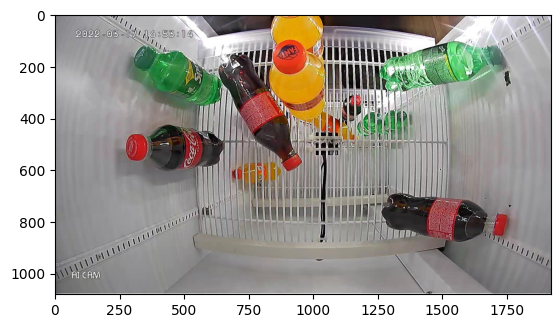

In [4]:
url = "https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/refrescos_nevera.jpg"
response = requests.get(url)

filename = url.split("/")[-1]

with open(filename, "wb") as file:
    file.write(response.content)

image = cv2.imread(filename)

# Mostrem la imatge utilitzant pyplot
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Carreguem el model

En primer lloc, carreguem un model YOLO pre-entrenat. Per carregar un model ja entrenat s'utilitza el métode `YOLO("yolov8l.pt")` on "yolov8l.pt" és el fitxer que conté el model pre-entrenat. El nostre model pre-entrenat és el YOLOv8 large; entrenat en les classes de COCO (80 classes).


In [5]:
model = YOLO("yolov8l.pt")

100%|██████████| 83.7M/83.7M [00:00<00:00, 396MB/s]


### Realitzar les prediccions

A continuació, farem les prediccions en el conjunt de dades d'entrada. Ens retornarà un objecte que es pot accedir com una llista. L'atribut que ens permetrà a les _bounding boxes_ és `boxes`.

In [6]:
results = model.predict(image)


0: 384x640 4 bottles, 1 cup, 1 refrigerator, 136.9ms
Speed: 14.6ms preprocess, 136.9ms inference, 696.0ms postprocess per image at shape (1, 3, 384, 640)


Mostrem a continuació les deteccions realitzades, les coordenades dels _bounding boxes_ i les classes detectades.

In [7]:
for r in results:
    for box in r.boxes:
        print(f"Coordenades de la caixa: {box.xyxy}")
        print(f"Confiança: {box.conf}")
        print(f"Classe: {box.cls}")
        print()

Coordenades de la caixa: tensor([[301.6774, 118.8555, 646.8502, 356.7832]], device='cuda:0')
Confiança: tensor([0.9430], device='cuda:0')
Classe: tensor([39.], device='cuda:0')

Coordenades de la caixa: tensor([[   4.5883,    0.0000, 1831.1184, 1056.7000]], device='cuda:0')
Confiança: tensor([0.8687], device='cuda:0')
Classe: tensor([72.], device='cuda:0')

Coordenades de la caixa: tensor([[8.2483e+02, 1.6937e-01, 1.0485e+03, 4.1574e+02]], device='cuda:0')
Confiança: tensor([0.8443], device='cuda:0')
Classe: tensor([39.], device='cuda:0')

Coordenades de la caixa: tensor([[271.3996, 425.2131, 654.9395, 609.3035]], device='cuda:0')
Confiança: tensor([0.6081], device='cuda:0')
Classe: tensor([39.], device='cuda:0')

Coordenades de la caixa: tensor([[1258.1553,  689.0667, 1677.1609,  882.2104]], device='cuda:0')
Confiança: tensor([0.4347], device='cuda:0')
Classe: tensor([39.], device='cuda:0')

Coordenades de la caixa: tensor([[1252.3898,  103.6075, 1729.8937,  304.7928]], device='cuda:0

### Visualitzar les deteccions

Finalment, visualitzarem les deteccions en les imatges d'entrada. Per això, utilitzarem la funció `plot_bounding_box_gallery` que ens permetrà visualitzar les imatges amb els _bounding boxes_ i les classes detectades.º

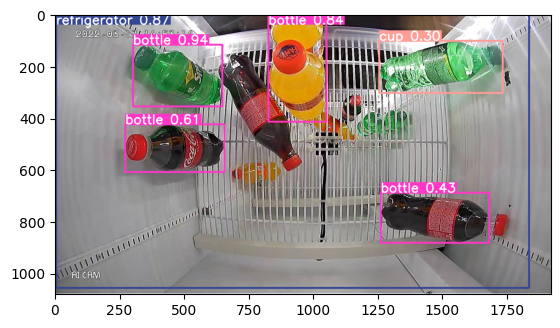

In [8]:
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

### Carreguem el Dataset

Anem a utilitzar un Dataset de Roboflow que conté imatges de neveres amb refrescos. Baixarem el dataset de Roboflow i el carregarem en el nostre entorn de treball.

Hauràs de donar-te d'alta a Roboflow i crear un _workspace_ per poder descarregar el dataset i obtindre el teu _api key_ (una vegada tingues el _workspace_ creat, pots obtindre la teua _api key_ en la secció de _settings_).

In [9]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.

In [10]:
from roboflow import Roboflow

rf = Roboflow(api_key="NBgSqd9Y698GNjySL0zP")
project = rf.workspace("roboflow-100").project("soda-bottles")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.37, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to soda-bottles-4 in yolov8:: 100%|██████████| 4510/4510 [00:01<00:00, 2395.51it/s]


In [11]:
dirname = dataset.location
dirname

'/content/soda-bottles-4'

Hem descarregat el dataset en format YOLO, ja que aquest és el format que utilitza la xarxa YOLO per entrenar-se.

A continuació l'entrenarem amb les imatges del dataset de refrescos.

Es probable que tingues un problema a l'hora d'executar la cel·la d'entrenament, ja que hi ha un error en el YAML de la configuració del dataset. Hauràs d'anar a `/content/soda-bottles-4` i editar el fitxer `data.yaml` per a que la ruta de les imatges siga correcta.y

L'entrenem durant 10 epochs, pero pots variar aquest nombre per veure els resultats.

In [14]:
results = model.train(data=f'{dataset.location}/data.yaml', epochs=10, imgsz=640, plots=True)

Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/soda-bottles-4/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 37.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 190MB/s]


AMP: checks passed ✅


train: Scanning /content/soda-bottles-4/train/labels... 1547 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1547/1547 [00:01<00:00, 982.10it/s] 

train: New cache created: /content/soda-bottles-4/train/labels.cache


WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 46, len(boxes) = 42756. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/soda-bottles-4/valid/labels... 486 images, 0 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:00<00:00, 1018.16it/s]


val: New cache created: /content/soda-bottles-4/valid/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      11.4G      1.758      1.617      1.786        322        640: 100%|██████████| 97/97 [00:38<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

                   all        486       9344      0.907      0.892       0.94      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      11.7G      1.497     0.7982      1.494        265        640: 100%|██████████| 97/97 [00:26<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


                   all        486       9344      0.936      0.923       0.95      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      11.7G      1.487     0.7671      1.472        317        640: 100%|██████████| 97/97 [00:25<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]


                   all        486       9344      0.935      0.917      0.951      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      11.7G      1.467     0.7428      1.447        302        640: 100%|██████████| 97/97 [00:25<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]


                   all        486       9344      0.942      0.923      0.955       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      11.8G      1.465     0.7321      1.441        274        640: 100%|██████████| 97/97 [00:25<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


                   all        486       9344       0.94      0.925      0.958       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      11.7G      1.452     0.7151      1.428        337        640: 100%|██████████| 97/97 [00:25<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]

                   all        486       9344      0.942      0.924      0.956      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      11.7G      1.438     0.6875      1.424        283        640: 100%|██████████| 97/97 [00:25<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]


                   all        486       9344      0.939      0.926      0.956      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      11.8G      1.426     0.6813      1.416        278        640: 100%|██████████| 97/97 [00:25<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

                   all        486       9344      0.937      0.925       0.96      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      11.8G      1.418      0.661      1.412        303        640: 100%|██████████| 97/97 [00:25<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

                   all        486       9344      0.945       0.93      0.962      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      11.7G      1.404     0.6579      1.401        330        640: 100%|██████████| 97/97 [00:25<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


                   all        486       9344      0.944      0.931      0.961      0.571

10 epochs completed in 0.097 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 87.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all        486       9344      0.944      0.931      0.961      0.571
             coca-cola        486       3144       0.94      0.923      0.953      0.562
                 fanta        486       2993      0.955      0.936      0.969      0.585
                sprite        486       3207      0.935      0.933       0.96      0.566
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


Una vegada entrenat hem de carregar el model per utilitzar-lo. En el nostre cas està en `/content/runs/detect/train3/weights/best.pt`.

Hem de crear un nou `YOLO` amb els nous pesos. Fem-ho i vejam els resultats.

In [22]:
model = YOLO(model="/content/runs/detect/train3/weights/best.pt")

In [23]:
results = model.predict(image)

for r in results:
    for box in r.boxes:
        print(f"Coordenades de la caixa: {box.xyxy}")
        print(f"Confiança: {box.conf}")
        print(f"Classe: {box.cls}")
        print()


0: 384x640 3 coca-colas, 2 fantas, 2 sprites, 17.8ms
Speed: 2.4ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Coordenades de la caixa: tensor([[266.3887, 424.1663, 656.1777, 607.6273]], device='cuda:0')
Confiança: tensor([0.7953], device='cuda:0')
Classe: tensor([0.], device='cuda:0')

Coordenades de la caixa: tensor([[ 824.7028,  100.7782, 1054.9537,  397.4837]], device='cuda:0')
Confiança: tensor([0.7725], device='cuda:0')
Classe: tensor([1.], device='cuda:0')

Coordenades de la caixa: tensor([[1258.7009,  691.8024, 1757.1830,  879.4038]], device='cuda:0')
Confiança: tensor([0.7725], device='cuda:0')
Classe: tensor([0.], device='cuda:0')

Coordenades de la caixa: tensor([[1253.6235,   99.7010, 1742.4839,  302.8761]], device='cuda:0')
Confiança: tensor([0.7592], device='cuda:0')
Classe: tensor([2.], device='cuda:0')

Coordenades de la caixa: tensor([[299.1898, 112.3876, 627.2909, 354.3101]], device='cuda:0')
Confiança: tensor([0.7518], device='

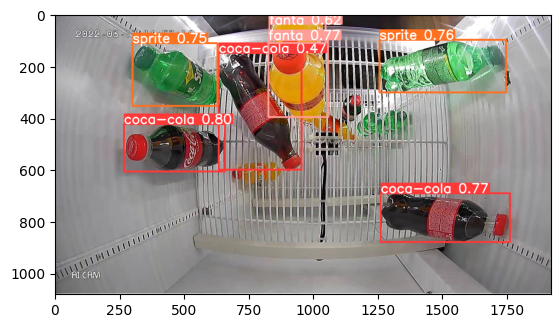

In [24]:
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

Ara els resultats han segut molt bons, en un entrenament molt breu.

Com hem vist YOLO es un llibreria molt potenta i que cal conèixer per poder integrar-la en els nostres projectes.